# Decoding through the epoch's window time the sentence / constituent embeddings

We:

- Calculate the embeddings for each sentence / constituent

- Decode it on the epoch window

- Plot it for each condition (level / start)


Todo: 

Integrate this:

```sent_starts = epochs['word_id==0'].apply_baseline((-.300, 0.))
sent_starts.average().plot()

sent_stops = epochs['is_last_word']
bsl = (epochs.times>-.300 )*(epochs.times<=0)
baseline_starts = sent_starts.get_data()[:, :, bsl].mean(-2)

sent_stop_data = sent_stops.get_data()
n_sentences, n_channels, n_times = sent_stop_data.shape
sent_stop_data -= baseline_starts[:, :, None]```


In [7]:
from dataset import read_raw, get_subjects, get_path, add_embeddings
from utils import decod_xy, mne_events
import mne
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import match_list
import spacy

In [8]:
def plot_scores(all_scores):
    from matplotlib.pyplot import figure

    figure(figsize=(16, 10), dpi=80)

    fig, axes = plt.subplots(3, 2)

    for axes_, level in zip( axes, levels):  
        for ax, start in zip( axes_, starts):  
            cond1 = all_scores.level==f'{level}'
            cond2 = all_scores.start==f'{start}'
            data = all_scores[ cond1 & cond2]
            y = []
            x = []
            for s, t in data.groupby('t'):
                score_avg = t.score.mean()
                y.append(score_avg)
                x.append(s)

            ax.plot(x,y)
            ax.set_title(f'{level} {start}')


In [9]:
def epoch_add_metadata(modality, subject, levels, starts, runs=9):
    """
    Takes as input subject number, modality, levels of epoching wanted (word, sentence, constituent)
    and starts (onset, offset) as well as the number of total runs (for debugging).
    
    Returns: 
    
    A dict of epochs objects, concatenated on the key (levels x starts)
    
    e.g: {'word_onset': <Epochs 10000 objects>, 'sentence_offset': <Epochs 1000 objects> ....}
    """
    dict_epochs = dict() # DICT containing epochs grouped by conditions (start x level)
    
    # Initialization of the dictionary
    for start in starts: 
            for level in levels:
                epoch_key = f'{level}_{start}'
                dict_epochs[epoch_key] = [] 
                
    # Iterating on runs, building the metadata and re-epoching
    for run in range(1,runs+1):
        raw, meta_, events = read_raw(subject, run, events_return = True, modality=modality)
        meta = meta_.copy()
        
        # Metadata update
        meta['word_onset'] = True
        meta['word_stop'] = meta.start + meta.duration
        meta['sentence_onset'] = meta.word_id == 0
        meta['prev_closing'] = meta['n_closing'].shift(1)
        meta['constituent_onset'] = meta.apply(lambda x: x['prev_closing'] > x['n_closing'] and x['n_closing'] == 1, axis=1)
        meta['constituent_onset'].fillna(False, inplace=True)
        meta.drop('prev_closing', axis=1, inplace=True)
        
        # Adding the sentence stop info
        meta['sentence_id'] = np.cumsum(meta.sentence_onset)
        for s, d in meta.groupby('sentence_id'):
            meta.loc[d.index, 'sent_word_id'] = range(len(d))
            meta.loc[d.index, 'sentence_start'] = d.start.min()
            last_word_duration = meta.loc[d.index.max(), 'duration']
            meta.loc[d.index, 'sentence_stop'] = d.start.max() + last_word_duration
            # Todo: Add the last word duration ? 
            
        # Adding the constituents stop info
        meta['constituent_id'] = np.cumsum(meta.constituent_onset)
        for s, d in meta.groupby('constituent_id'):
            meta.loc[d.index, 'const_word_id'] = range(len(d))
            meta.loc[d.index, 'constituent_start'] = d.start.min()
            last_word_duration = meta.loc[d.index.max(), 'duration']
            meta.loc[d.index, 'constituent_stop'] = d.start.max() + last_word_duration
            # Todo: Add the last word duration ? 
        
        # Adding embeddings info
        meta = add_embeddings(meta, run, 'constituent')
        meta = add_embeddings(meta, run, 'sentence')
        
        embeddings = meta.word.apply(lambda word: nlp(word).vector).values
        meta['embeds_word'] = embeddings
        for start in starts: 
            for level in levels:
                # Select only the rows containing the True for the conditions
                # Simplified to only get for the onset: sentence onset epochs, constituent onset epochs,etc
                sel = meta.query(f'{level}_onset==True')
                assert sel.shape[0] > 10  #

                # Epoching from the metadata having all onset events: if the start=Offset, the mne events
                # Function will epoch on the offset of each level instead of the onset
                # TODO: add adaptative baseline
                epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
                                     tmin = epoch_windows[f'{level}'][f'{start}_min'],
                                       tmax = epoch_windows[f'{level}'][f'{start}_max'],
                                         event_repeated = 'drop',
                                            preload=True,
                                                baseline=None)
                epoch_key = f'{level}_{start}'

                dict_epochs[epoch_key].append(epochs)
            
    # Once we have the dict of epochs per condition full (epoching for each run for a subject)
    # we can concatenate them, and fix the dev_head             
    for start_ in starts: 
        for level_ in levels:
            epoch_key = f'{level_}_{start_}'
            all_epochs_chosen = dict_epochs[epoch_key]
            # Concatenate epochs

            for epo in all_epochs_chosen:
                epo.info["dev_head_t"] = all_epochs_chosen[1].info["dev_head_t"]

            dict_epochs[epoch_key] = mne.concatenate_epochs(all_epochs_chosen)
            
    return dict_epochs

In [10]:
def decoding_from_criterion(criterion, dict_epochs, starts, levels):
    """
    Input:
    - criterion: the criterion on which the decoding will be done (embeddings, wlength, w_freq, etc..)
    - dict_epochs: the dictionnary containing the epochs for each condition (starts x levels)
    - starts: (onset, offset)
    - levels: (word, sentence, constituent)
    
    Returns:
    Two dataframes: 
    - all_scores: decoding scores for each subject / starts x levels
    - all_evos: ERP plots for each subject / starts x levels
    
    
    """
    
    all_evos = []
    all_scores = []
    # All epochs -> Decoding and generate evoked potentials
    for start in starts: 
        for level in levels:
            epoch_key = f'{level}_{start}'
            epochs = dict_epochs[epoch_key]
            # mean
            evo = epochs.copy().pick_types(meg=True).average(method='median')
            all_evos.append(dict(subject=subject, evo=evo, start=start, level=level))


            # decoding word emb
            epochs = epochs.load_data().pick_types(meg=True, stim=False, misc=False)
            X = epochs.get_data()
            if criterion == 'emb_sentence' or criterion == 'emb_constituent':
                embeddings = epochs.metadata[f'embeds_{level}']
                embeddings = np.vstack(embeddings.values)
                R_vec = decod_xy(X, embeddings)
                scores = np.mean(R_vec, axis=1)
            elif criterion == 'emb_word':
                nlp = spacy.load("fr_core_news_sm")
                embeddings = epochs.metadata.word.apply(lambda word: nlp(word).vector).values
                embeddings = np.array([emb for emb in embeddings])
                R_vec = decod_xy(X, embeddings)
                scores = np.mean(R_vec, axis=1)
            elif criterion == 'wlength':
                y = epochs.metadata.wlength
                R_vec = decod_xy(X, y)
                scores = R_vec

            for t, score in enumerate(scores):
                all_scores.append(dict(subject=subject, score=score, start=start, level=level, t=epochs.times[t]))
    all_scores = pd.DataFrame(all_scores)
    all_evos = pd.DataFrame(all_evos)
    return all_scores, all_evos

In [23]:
modality = "visual"
nlp = spacy.load("fr_core_news_sm")
path = get_path(modality)
subjects = get_subjects(path)
runs = 9
decoding_criterion = 'wlength'
epoch_windows = {"word": {"onset_min": -0.3, "onset_max": 1.0, "offset_min": -1.0, "offset_max": 0.3},
                  "constituent": {"offset_min": -2.0, "offset_max": 0.5, "onset_min": -0.5, "onset_max": 2.0},
                  "sentence": {"offset_min": -4.0, "offset_max": 1.0, "onset_min": -1.0, "onset_max": 4.0}}
levels = ('word','constituent','sentence')
starts = ('onset', 'offset')

if isinstance(levels, str):
    levels = [levels]
    
if isinstance(starts, str):
    starts = [starts]
      
# Iterate on subjects to epochs, and mean later
for subject in subjects[2:5]:
    dict_epochs = epoch_add_metadata(modality, subject, levels, starts, runs)
    
    all_scores, all_evos = decoding_from_criterion(decoding_criterion, dict_epochs, starts, levels)

Reading raw files for modality: visual

 Epoching for run 1, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-01_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 36000 ... 517999 =     36.000 ...   517.999 secs
Ready.
Reading e

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 81 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


Trigger channel has a non-zero initial value of 8 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
1466 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Reading 0 ... 481999  =      0.000 ...   481.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.2s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1412 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1412 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
433 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 433 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 130 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1412 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1412 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
446 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 446 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: visual

 Epoching for run 2, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-02_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 14000 ... 532999 =     14.000 ...   532.999 

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 99 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI

1607 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Reading 0 ... 518999  =      0.000 ...   518.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.8s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1563 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1563 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
460 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 460 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
123 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 123 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1563 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1563 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
476 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 476 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
141 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 141 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


2 bad epochs dropped
Reading raw files for modality: visual

 Epoching for run 3, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-03_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 566999 =     12.000 ...   566.999 

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 146 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, ST

1719 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Reading 0 ... 554999  =      0.000 ...   554.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    7.3s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
510 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 510 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1660 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1660 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
540 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 540 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
184 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 184 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: visual

 Epoching for run 4, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-04_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 11000 ... 500999 =     11.000 ...   500.999 

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 134 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, STI009, STI010, STI011, STI012, STI013, STI014, STI015, STI016, STI101, STI201, STI301 has changed from V to NA.
  raw = mne_bids.read_raw_bids(bids_path)


1491 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19]
Reading 0 ... 489999  =      0.000 ...   489.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.7s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1444 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1444 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
443 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 443 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
130 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 130 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1444 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1444 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
458 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 458 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: visual

 Epoching for run 5, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-05_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 12000 ... 472999 =     12.000 ...   472.999 

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 121 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, ST

1373 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 16 20]
Reading 0 ... 460999  =      0.000 ...   460.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.1s finished


Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1336 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
397 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 397 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
149 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 149 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Adding metadata with 31 columns
1336 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1336 events and 1301 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Adding metadata with 31 columns
414 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 414 events and 2501 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


0 bad epochs dropped
Adding metadata with 31 columns
167 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 167 events and 5001 original time points (prior to decimation) ...


/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The events passed to the Epochs constructor are not chronologically ordered.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,
/tmp/ipykernel_622855/3594698081.py:68: RuntimeWarning: The measurement information indicates a low-pass frequency of 20.0 Hz. The decim=100 parameter will result in a sampling frequency of 10.0 Hz, which can cause aliasing artifacts.
  epochs = mne.Epochs(raw, **mne_events(sel, raw ,start=start, level=level), decim = 100,


1 bad epochs dropped
Reading raw files for modality: visual

 Epoching for run 6, subject: 3

Opening raw data file /home/is153802/data/LPP_MEG_visual/sub-3/ses-01/meg/sub-3_ses-01_task-read_run-06_meg.fif...
    Read a total of 13 projection items:
        grad_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        grad_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v1 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v2 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v3 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v4 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v5 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v6 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v7 (1 x 306)  idle
        mag_ssp_upright.fif : PCA-v8 (1 x 306)  idle
    Range : 9000 ... 575999 =      9.000 ...   575.999 s

/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: This file contains raw Internal Active Shielding data. It may be distorted. Elekta recommends it be run through MaxFilter to produce reliable results. Consider closing the file and running MaxFilter on the data.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Omitted 139 annotation(s) that were outside data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw = mne_bids.read_raw_bids(bids_path)
/mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py:55: RuntimeWarning: The unit for channel(s) STI001, STI002, STI003, STI004, STI005, STI006, STI007, STI008, ST

1698 events found
Event IDs: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
Reading 0 ... 566999  =      0.000 ...   566.999 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 6601 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 306 out of 306 | elapsed:    6.9s finished


KeyError: 178

In [ ]:
%debug

> /mnt/localdrive/workspace-LPP/code/neurospin-petit-prince/decoding/local_testing/dataset.py(688)add_embeddings()
    686     embed_arrays = []
    687     for index, row in meta.iterrows():
--> 688         embed_arrays.append(embeddings[sent_index])
    689         # Check if end of sentence
    690         if row['is_last_word']:

ipdb> embeds.shape
(1024,)
ipdb> sentences
['La sixième planète était une planète dix fois plus vaste.', "Elle était habitée par un vieux monsieur qui écrivait d'énormes livres.", "«tiens! Voilà un explorateur!» S'écria-t-il, quand il aperçut le petit prince.", "Le petit prince s'assit sur la table et souffla un peu.", 'Il avait déjà tant voyagé!', "«d'où viens-tu? Lui dit le vieux monsieur.", 'Quel est ce gros livre?', 'Dit le petit prince.', 'Que faites-vous ici? Je suis géographe, dit le vieux monsieur.', "Qu'est-ce qu'un géographe?", "C'est un savant qui connaît où se trouvent les mers, les fleuves, les villes, les montagnes et les déserts.", "Ça c'est

ipdb> len(sentences)
178
ipdb> meta
      Unnamed: 0          word  onset  duration  \
0              0            La    0.7      0.25   
1              1       sixième    1.0      0.25   
2              2       planète    1.3      0.25   
3              3         était    1.6      0.25   
4              4           une    1.9      0.25   
...          ...           ...    ...       ...   
1691        1691          elle  620.5      0.25   
1692        1692       parlait  620.8      0.25   
1693        1693      toujours  621.1      0.25   
1694        1694            la  621.4      0.25   
1695        1695  première...»  621.7      0.25   

                                 trial_type  wlength  n_closing  is_last_word  \
0            {'kind': 'word', 'word': 'La'}        2          1         False   
1       {'kind': 'word', 'word': 'sixième'}        7          1         False   
2       {'kind': 'word', 'word': 'planète'}        7          2         False   
3         {'kind': 'word', 

ipdb> meta.colunms
*** AttributeError: 'DataFrame' object has no attribute 'colunms'
ipdb> meta.columns
Index(['Unnamed: 0', 'word', 'onset', 'duration', 'trial_type', 'wlength',
       'n_closing', 'is_last_word', 'pos', 'content_word', 'sequence_id',
       'word_id', 'has_trigger', 'start', 'word_onset', 'word_stop',
       'sentence_onset', 'constituent_onset', 'sentence_id', 'sent_word_id',
       'sentence_start', 'sentence_stop', 'constituent_id', 'const_word_id',
       'constituent_start', 'constituent_stop', 'const_end',
       'embeds_constituent'],
      dtype='object')


<Figure size 1280x800 with 0 Axes>

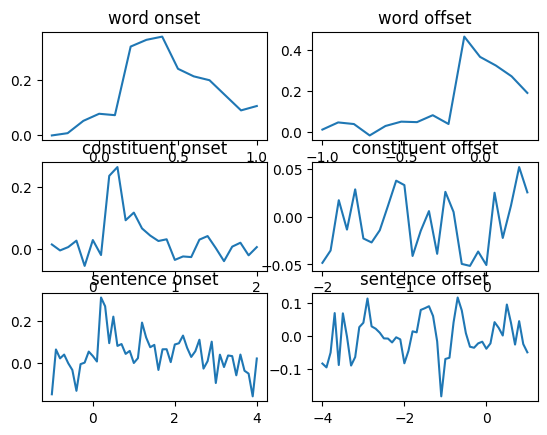

In [12]:
plot_scores(all_scores)

<Figure size 1280x800 with 0 Axes>

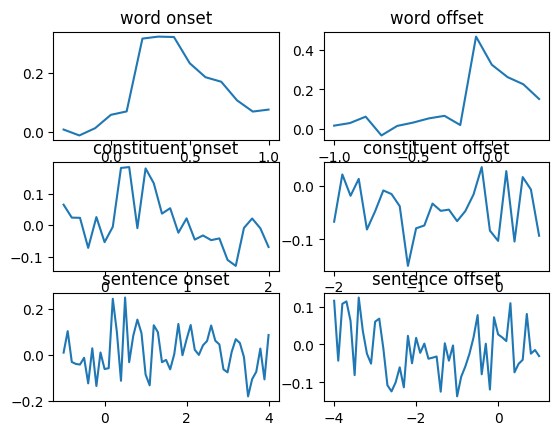

In [13]:
plot_scores(all_scores)

In [ ]:
dict_epochs['word_onset'].metadata.keys